Implementing a Simple VAE using PyTorch
Import the modules neccessary to run

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
import random
from ipdb import set_trace as st

In [2]:
import sys
sys.argv=['']
del sys

we will define the argument parser to parse the command line arguments. We will provide the number of epochs to train for as the argument while executing the file from the command line. The following block of code constructs the argument parser.

In [3]:
# construct the argument parser and parser the arguments
parser = argparse.ArgumentParser(description='VAE Example')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

torch.manual_seed(args.seed)

# we use CPU for computation
device = torch.device("cpu")

K = 1024

Generate the standard toy "8-gaussians" dataset,

In [4]:
def data_gen(BATCH_SIZE):
    #8 gaussians
    while 1:
        theta = (np.pi/4) * torch.randint(0, 8, (BATCH_SIZE,)).float().to(device)
        centers = torch.stack((torch.cos(theta), torch.sin(theta)), dim = -1)
        noise = torch.randn_like(centers) * 0.1
        yield centers + noise


we have to define the train and test data loaders. We can easily do that using the DataLoader module from PyTorch

In [5]:
test_loader = train_loader = data_gen(args.batch_size)


We will define the VAE
First we have the __init__() function
The VAE consists of an encoder that takes the  outputs 2 vectors of length latent_size
The reparametrize() function 
It has two parameters mu and log_var.
mu is the mean that is coming from encoder’s latent space encoding.
And logvar is the log variance that is coming from the encoder’s latent space.
first, we calculate the standard deviation (std) using the logvar.
Then , we calculate epsilon (eps) that we will use in the sample formula. We use torch.rand_like() so that dimensions will be same as std.
finally we calculate the sample using mu, eps, std. Then we return its value. 
Then we start forward() function
First,  pass the input through the VAE’s encoder layers. 
Then we get mu and log_var . These two have the same value as the encoder’s last layer output.
then, we get the latent vector z through reparameterization trick using mu and log_var.
next we have the decoding part. We pass the latent vector z through the first decoder layer. Then we get the reconstruction of the inputs by giving that output as input to the second decoder layer.
Finally,  return the reconstruction, mu, and logvar values.

In [17]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(2, K)
        self.fc1 = nn.Linear(K, K)
        self.fc21 = nn.Linear(K, K)
        self.fc22 = nn.Linear(K, K)
        self.fc3 = nn.Linear(K, K)
        self.fc4 = nn.Linear(K, K)
        self.fc5 = nn.Linear(K, 2)

    def encode(self, x):
        h1 = F.selu(self.fc1(F.selu(self.fc0(x))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.fc5(F.selu(self.fc4(F.selu(self.fc3(z)))))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 2))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



We will start initialing the model and loading it onto the computation device. Then we will define the optimizer and the loss function.We are using the Adam optimizer for training. then adjust the learning rate based on the number of epochs and with ReduceLROnPlateau allows dynamic learning rate reducing based on some validation measurements.

In [18]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose = True, threshold = 1E-2, eps=1e-6)

we will write the function to calculate the total loss while training the autoencoder model.  it is going to be the addition of the KL Divergence loss and the reconstruction loss.
First we initialize the L2 loss at line 11.
then, we calculate the KL divergence using the mu and logvar values.
Finally, we return the total loss 

In [19]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 2), reduction='sum')
    L2 = torch.mean((recon_x-x)**2)
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return L2 + KLD

We will define the training function here
first we initialize train_loss to keep track of the batch-wise loss values.
flattens the input data as we are going to feed it into a linear layer.
then, we get the reconstruction, mu, and log_var.
and calculates the reconstruction loss using the reconstructed data and the original input data.
after that we calculate the total loss using the total_loss function.
We calculate the batch loss . Then we backpropagate the gradients and update the parameters .
Finally, we calculate the total loss for the epoch (train_loss) and print its value.

In [20]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break #100 batches per epoch
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= 100
    scheduler.step(train_loss)
    print (train_loss)

We have all the code ready to train our VAE on the toy dataset
we execute that for 10 epoche because it takes a long time to execute and finally plot 
the samples from the 8-gaussians dataset(red points)
and sampled from the trained model(blue points)
and 8-gaussians is actually a non-trivial task for many other generative models, but the mass is concentrated in the right places

0.3668243182450533
0.03290087191388011
0.014557129591703416
0.011395663553848863
0.010156577713787555
0.009443376027047635
0.009505090145394206
0.009199871281161905
0.009112687641754746
0.009022791031748056


__main__:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


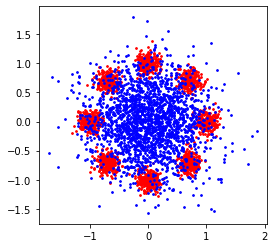

--Return--
None
> <ipython-input-21-058ac036ab64>(24)<module>()
     22     plt.show()
     23 
---> 24     st()



In [ ]:
if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)

    gt = next(train_loader)
        
    with torch.no_grad():
        sample = torch.randn(2048, K).to(device)
        out = model.decode(sample).cpu().numpy()
        recon = model(gt)[0].cpu().numpy()

    rx,ry = recon[:,0], recon[:,1]
        
    gt = gt.cpu().numpy()
    gx, gy = gt[:,0], gt[:,1]
        
    xs, ys = out[:,0], out[:,1]

    plt.scatter(gx, gy, c = 'red', s=3)
    plt.scatter(xs, ys, c = 'blue', s=3)
    plt.axes().set_aspect('equal')
    plt.show()
    
    st()


In [16]:
from PIL import Image


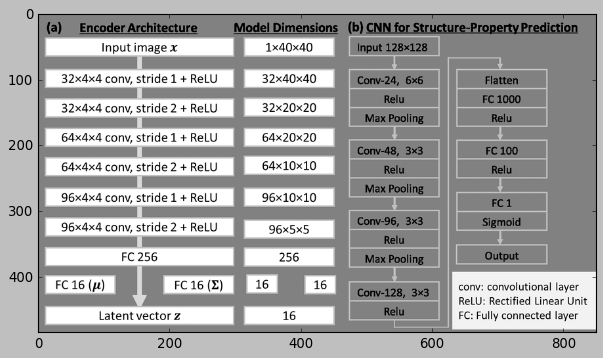

In [22]:
plt.style.use('classic')
img = Image.open('vae1.png')
# convert image to grayscale
imggray = img.convert('LA')
# convert to numpy array
imgmat = np.array(list(imggray.getdata(band=0)), float)
# Reshape according to orginal image dimensions
imgmat.shape = (imggray.size[1], imggray.size[0])

plt.figure(figsize=(9, 6))
plt.imshow(imgmat,cmap='gray')
plt.show()

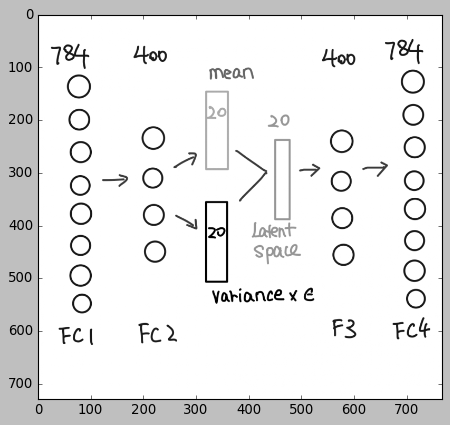

In [24]:
plt.style.use('classic')
img = Image.open('vae2.png')
# convert image to grayscale
imggray = img.convert('LA')
# convert to numpy array
imgmat = np.array(list(imggray.getdata(band=0)), float)
# Reshape according to orginal image dimensions
imgmat.shape = (imggray.size[1], imggray.size[0])

plt.figure(figsize=(9, 6))
plt.imshow(imgmat, cmap='gray')
plt.show()

In [7]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D # this is needed for working 3d projection

%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [8]:
np.random.seed(1016)

In [9]:
# make meshgrid
theta0_axis = np.linspace(-3,3,101)
theta1_axis = np.linspace(-3,3,101)
X, Y = np.meshgrid(theta0_axis,theta1_axis)

In [10]:
def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection), figsize=(12,4))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.3, cmap=plt.cm.jet)
        ax[1].plot_surface(X, Y, likelihood, alpha=0.3, cmap=plt.cm.jet)
        ax[2].plot_surface(X, Y, posterior, alpha=0.3, cmap=plt.cm.jet)
    else:
        ax[0].contour(X, Y, prior, cmap=plt.cm.jet)
        ax[1].contour(X, Y, likelihood, cmap=plt.cm.jet)
        ax[2].contour(X, Y, posterior, cmap=plt.cm.jet)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.tight_layout()

In [11]:
np.random.seed(1016)

In [12]:
sig1,sig2,sigx = np.sqrt(10),1,np.sqrt(2)
mean_stddev = np.array([[0,sigx],
                        [2,sigx]])
n_sample = 100
mixture_idx = np.random.choice(2,size=n_sample,p=[0.5,0.5])
samples = np.array([st.norm(*mean_stddev[idx]).rvs() for idx in mixture_idx])
print(samples.shape)
# plt.hist(samples,bins=20)

(100,)


In [13]:
prior = lambda thetas: st.norm(0,sig1).pdf(thetas[0]) * st.norm(0,sig2).pdf(thetas[1])

def likelihood(thetas):
    data_likelihood = lambda thetas,data: \
                            (st.norm(thetas[0],sigx).pdf(data) + \
                             st.norm(thetas[0]+thetas[1],sigx).pdf(data)) / 2
    loglikelihood = np.ones(X.shape)
    for sample in samples:
        loglikelihood *= data_likelihood(thetas,sample)
    return loglikelihood

def post(thetas): 
    unnorm_post = lambda thetas: prior(thetas) * likelihood(thetas)
    post = unnorm_post(thetas)
    post = post / (post.sum() * 36. / 10000.)
    return post

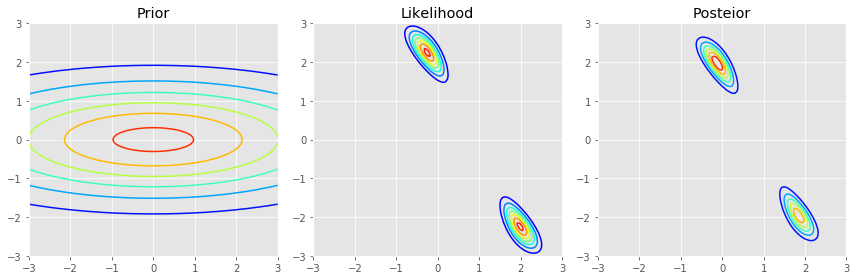

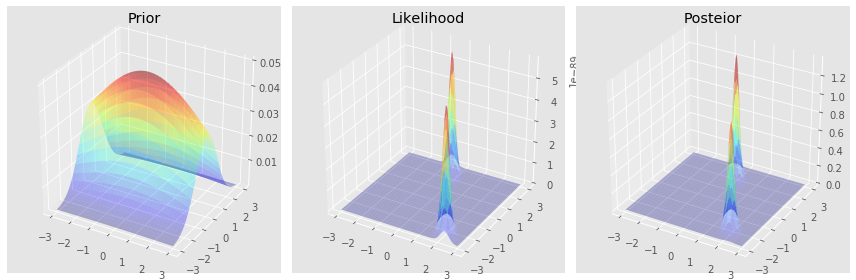

In [14]:
make_plots(X, Y, prior([X,Y]), likelihood([X,Y]), post([X,Y]))
make_plots(X, Y, prior([X,Y]), likelihood([X,Y]), post([X,Y]), projection='3d')